In [1]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from torch.utils.tensorboard import SummaryWriter
from torchtext.legacy.data import Field, BucketIterator, TabularDataset
from torch.utils.data import Dataset, DataLoader
import sys
import os
import math
from ProteinTransformer import *
from utils import *
from ProteinsDataset import *

In [3]:
import seaborn
def draw(data, x, y):
    seaborn.heatmap(data, 
                    xticklabels=x, square=True, yticklabels=y, vmin=0.0,# vmax=1.0, 
                    cbar=False)

In [4]:
# pds = ProteinTranslationDataset(datasetPath, device=device, Unalign=False)
# train_iterator = DataLoader(pds, batch_size=1,shuffle=True, num_workers=0, collate_fn=default_collate)
# batch = next(iter(train_iterator))

In [5]:

# pds.tensorIN=pds.tensorIN[:,torch.randperm(pds.tensorIN.size()[1]),:]
# pds.tensorOUT=pds.tensorOUT[:,torch.randperm(pds.tensorOUT.size()[1]),:]
# train_iterator = DataLoader(pds, batch_size=1,shuffle=True, num_workers=0, collate_fn=default_collate)
# batch = next(iter(train_iterator))

In [6]:
len_input = 103
len_output = 120
embedding_size = 25
datasetPath = "combined_MSA_ddi_17_joined_test.csv"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pds = ProteinTranslationDataset(datasetPath, device=device, Unalign=False)
src_pad_idx = pds.SymbolMap["<pad>"]

num_heads = 5
num_encoder_layers = 4
num_decoder_layers = 4
dropout = 0.10
forward_expansion = 4096
src_vocab_size = 25
trg_vocab_size = 25
src_position_embedding = PositionalEncoding(embedding_size, max_len=len_input,device=device)
trg_position_embedding = PositionalEncoding(embedding_size, max_len=len_output, device=device)

model = Transformer(
    embedding_size,
    src_vocab_size,
    trg_vocab_size,
    src_pad_idx,
    num_heads,
    num_encoder_layers,
    num_decoder_layers,
    forward_expansion,
    dropout,
    src_position_embedding,
    trg_position_embedding,
    device,
).to(device)

model2 = Transformer(
    embedding_size,
    src_vocab_size,
    trg_vocab_size,
    src_pad_idx,
    num_heads,
    num_encoder_layers,
    num_decoder_layers,
    forward_expansion,
    dropout,
    src_position_embedding,
    trg_position_embedding,
    device,
).to(device)

model3 = Transformer(
    embedding_size,
    src_vocab_size,
    trg_vocab_size,
    src_pad_idx,
    num_heads,
    num_encoder_layers,
    num_decoder_layers,
    forward_expansion,
    dropout,
    src_position_embedding,
    trg_position_embedding,
    device,
).to(device)

keeping the gap
cuda:0
cuda:0


In [7]:
nlayer = len(model.transformer.decoder.layers)
for i in range(nlayer):
    model.transformer.decoder.layers[i].saveAttention = True
    
nlayer = len(model2.transformer.encoder.layers)
for i in range(nlayer):
    model2.transformer.decoder.layers[i].saveAttention = True
    
nlayer = len(model3.transformer.encoder.layers)
for i in range(nlayer):
    model3.transformer.decoder.layers[i].saveAttention = True

In [8]:
learning_rate = 3e-4

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
load_checkpoint(torch.load("fam17Pos.pth.tar"), model, optimizer)
load_checkpoint(torch.load("fam17Str.pth.tar"), model2, optimizer)
load_checkpoint(torch.load("fam17StrV2.pth.tar"), model3, optimizer)

=> Loading checkpoint
=> Loading checkpoint
=> Loading checkpoint


In [10]:
pdbin=[]
pdbin[:]= "---------------DGTKLSFEWHEDVSLITVLYQSNVQNLQVETAAGYQDIEADDTGYLINCGSYMAHLTNNYYKAPIHRVKWVNA--ERQSLPFFVN-"
pdbout=[]
pdbout[:]= "VPKIDVSPLDDQAAKMRVAQQIDAASRDTGFFYAVNHGINV---QRLSQKTKEFHSITPEEKWDLAINKEHQDQVRAGYYLSIPGKKAVESFCYLNPNFTPDHPAKTPTHEVNVWPD-"
seqin = [pds.SymbolMap[pds.init_token]]+[pds.SymbolMap[i] for i in pdbin]+[pds.SymbolMap[pds.eos_token]]
seqout = [pds.SymbolMap[pds.init_token]]+[pds.SymbolMap[i] for i in pdbout]+[pds.SymbolMap[pds.eos_token]]
inp1o = torch.nn.functional.one_hot(torch.tensor(seqin), num_classes=25).unsqueeze(1).to(pds.device)
targ1o = torch.nn.functional.one_hot(torch.tensor(seqout), num_classes=25).unsqueeze(1).to(pds.device)

In [11]:
val_iterator = DataLoader(pds, batch_size=32,
                        shuffle=True, num_workers=0, collate_fn=default_collate)
criterion = nn.CrossEntropyLoss(ignore_index=pds.SymbolMap["<pad>"], reduction='none')

In [23]:
train_iterator = DataLoader(pds, batch_size=1,shuffle=True, num_workers=0, collate_fn=default_collate)

batch = next(iter(train_iterator))
inp_data, target= batch[0], batch[1]
output = model(inp_data, target[:-1, :])
output = model2(inp_data, target[:-1, :])
output = model3(inp_data, target[:-1, :])
_, o =torch.max(inp_data, dim=2)
inv_map = {v: k for k, v in pds.SymbolMap.items()}
inputsequence = [inv_map[o[i,0].item()] for i in range(o.shape[0])]

_, ot =torch.max(target[:-1, :], dim=2)

targetsequence = [inv_map[ot[i,0].item()] for i in range(ot.shape[0])]
print(len(inputsequence), len(targetsequence))



103 119


In [66]:

# einops.repeat(x, 'm n -> m k n', k=K)
a = torch.tensor(range(24))
print(a)
print(a.reshape(3,2,4))
a = a.reshape(3,2,4).float()
el = a[:,0,:].unsqueeze(1)
el.repeat(1,2,1)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23])
tensor([[[ 0,  1,  2,  3],
         [ 4,  5,  6,  7]],

        [[ 8,  9, 10, 11],
         [12, 13, 14, 15]],

        [[16, 17, 18, 19],
         [20, 21, 22, 23]]])


tensor([[[ 0.,  1.,  2.,  3.],
         [ 0.,  1.,  2.,  3.]],

        [[ 8.,  9., 10., 11.],
         [ 8.,  9., 10., 11.]],

        [[16., 17., 18., 19.],
         [16., 17., 18., 19.]]])

In [69]:
a = torch.tensor(range(24))
print(a)
print(a.reshape(3,2,4))
a = a.reshape(3,2,4).float()
# print(a.reshape(-1))
ab = a.reshape(-1, a.shape[2]) 
_, b = a.max(dim=2)
b = b.reshape(-1)
# # a = a.reshape(2,2,4).float()
# # ab = a.reshape(-1, a.shape[2]) 
# # _, b = a.max(dim=2)
# # print(b)
# print(b)
criterion(ab, b).reshape(3,2).mean(dim=0)



tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23])
tensor([[[ 0,  1,  2,  3],
         [ 4,  5,  6,  7]],

        [[ 8,  9, 10, 11],
         [12, 13, 14, 15]],

        [[16, 17, 18, 19],
         [20, 21, 22, 23]]])


tensor([0.4402, 0.4402])

In [70]:
def makesquaredLoss(batch, model, criterion, criterionMatching, device):
    inp_data, target= batch[0], batch[1]
    bs = inp_data.shape[1]
    lossMatrix = torch.zeros((bs,bs)).to(device)
    LossCE = torch.tensor(0.0).to(device)
    for i in range(bs):
        inp_repeted = inp_data[:,i,:].unsqueeze(1).repeat(1,bs,1)
        # print(i, inp_repeted.shape)
        output = model(inp_repeted, target[:-1, :])
        output = output.reshape(-1, output.shape[2])#keep last dimension
        _, targets_Original = target.max(dim=2)
        targets_Original = targets_Original[1:].reshape(-1)
        loss = criterion(output, targets_Original).reshape(-1,bs).mean(dim=0)
        lossMatrix[i,:] = loss
        LossCE += loss[i]
    LossCE /=bs
    lossMatrix = torch.nn.functional.softmax(lossMatrix, dim=0)
    targetMatching = torch.tensor(range(bs)).to(device)
    lossMatching = criterionMatching(lossMatrix, targetMatching)
    return LossCE, lossMatching
    

In [92]:
criterion = nn.CrossEntropyLoss(ignore_index=pds.SymbolMap["<pad>"])#, reduction='none')
criterionMatching = nn.CrossEntropyLoss()
model.eval()
losses_eval = []
count = 0
with  torch.no_grad():
    for batch_idx, batch in enumerate(val_iterator):
        count+=1
# #         LossCE, lossMatching = makesquaredLoss(batch, model, criterion, criterionMatching, device)
#         print(LossCE, lossMatching)
        inp_data, target= batch[0], batch[1]
        print(inp_data.shape, target.shape)
        inp_data = inp_data.to(device)
        output = model(inp_data, target[:-1, :])
        output = output.reshape(-1, output.shape[2]) #keep last dimension
        print("output", output.shape)
        _, targets_Original = target.max(dim=2)
        targets_Original = targets_Original[1:].reshape(-1)
        loss_eval = criterion(output, targets_Original)
        print("loss",loss_eval, loss_eval.shape)
        losses_eval.append(loss_eval.item())
#         att += model.transformer.decoder.layers[0].savedAttention.cpu().detach().numpy()[0,:,:]
# mean_lossVal = sum(losses_eval) / len(losses_eval)
# att /=count

torch.Size([103, 32, 25]) torch.Size([120, 32, 25])
output torch.Size([3808, 25])
loss tensor(4.9970, device='cuda:0') torch.Size([])
torch.Size([103, 32, 25]) torch.Size([120, 32, 25])
output torch.Size([3808, 25])
loss tensor(4.5809, device='cuda:0') torch.Size([])
torch.Size([103, 32, 25]) torch.Size([120, 32, 25])
output torch.Size([3808, 25])
loss tensor(5.1191, device='cuda:0') torch.Size([])
torch.Size([103, 32, 25]) torch.Size([120, 32, 25])
output torch.Size([3808, 25])
loss tensor(4.8822, device='cuda:0') torch.Size([])
torch.Size([103, 32, 25]) torch.Size([120, 32, 25])
output torch.Size([3808, 25])
loss tensor(4.7548, device='cuda:0') torch.Size([])
torch.Size([103, 32, 25]) torch.Size([120, 32, 25])
output torch.Size([3808, 25])
loss tensor(4.4528, device='cuda:0') torch.Size([])
torch.Size([103, 32, 25]) torch.Size([120, 32, 25])
output torch.Size([3808, 25])
loss tensor(4.9175, device='cuda:0') torch.Size([])
torch.Size([103, 32, 25]) torch.Size([120, 32, 25])
output tor

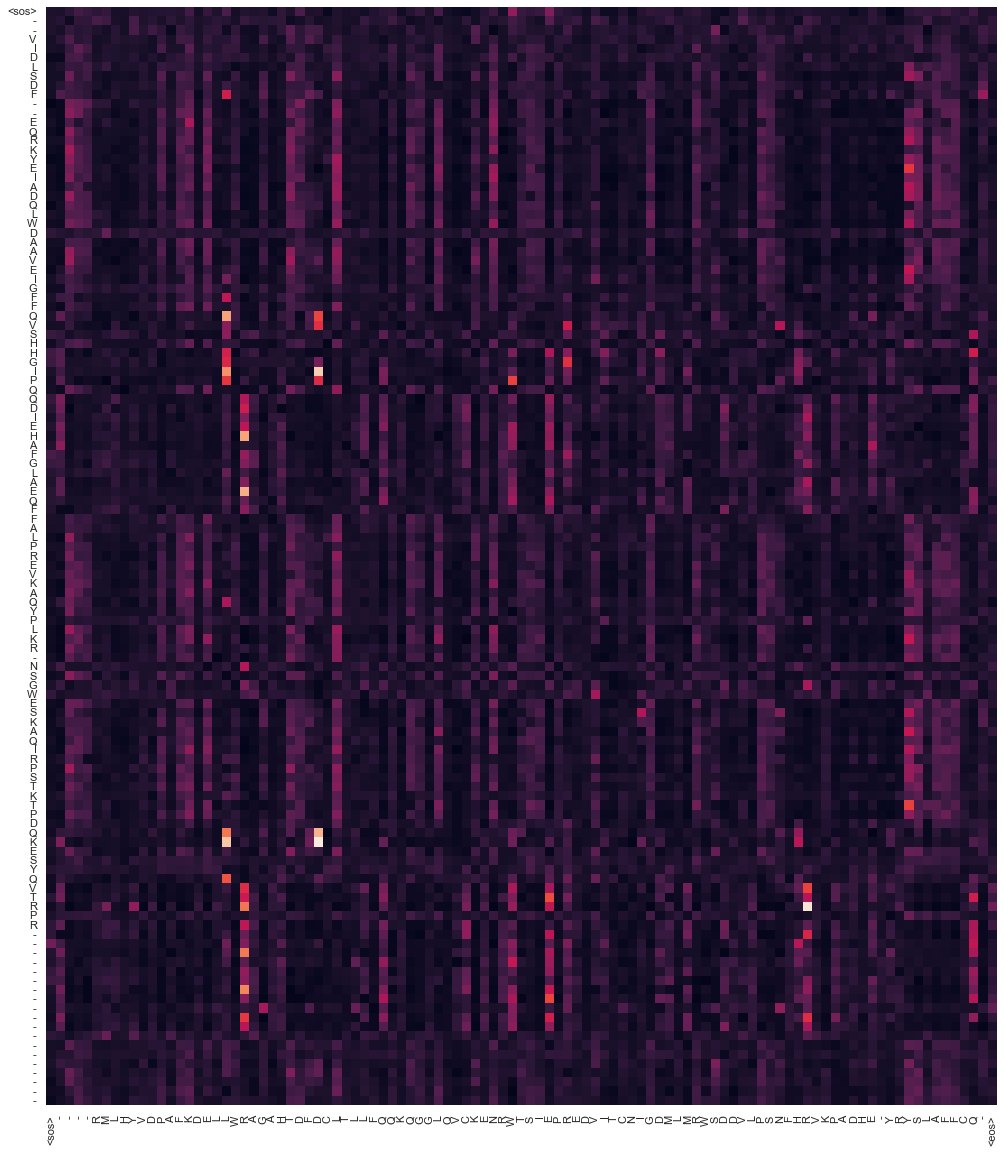

In [270]:
draw(model.transformer.decoder.layers[0].savedAttention.cpu().detach().numpy()[0,:,:],inputsequence, targetsequence )

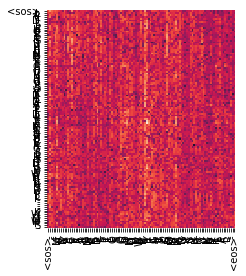

In [91]:
draw(model2.transformer.decoder.layers[0].savedAttention.cpu().detach().numpy()[0,:,:],inputsequence, targetsequence )

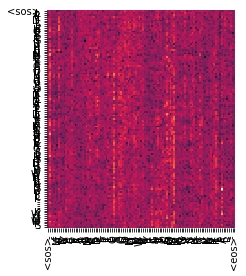

In [92]:
draw(model3.transformer.decoder.layers[0].savedAttention.cpu().detach().numpy()[0,:,:],inputsequence, targetsequence )

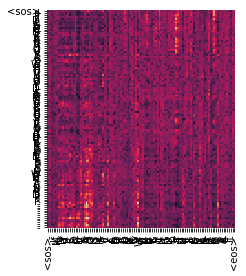

In [71]:
draw(model.transformer.decoder.layers[1].savedAttention.cpu().detach().numpy()[0,:,:],inputsequence, targetsequence )

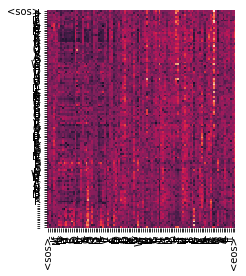

In [72]:
draw(model.transformer.decoder.layers[2].savedAttention.cpu().detach().numpy()[0,:,:],inputsequence, targetsequence )

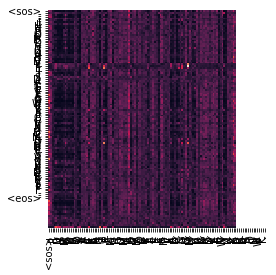

In [62]:
draw(model.transformer.decoder.layers[3].savedAttention.cpu().detach().numpy()[0,:,:], targetsequence, inputsequence )

In [27]:
draw(model.transformer.decoder.layers[4].savedAttention.cpu().detach().numpy()[0,:,:], targetsequence, inputsequence )

IndexError: index 4 is out of range

In [24]:
model.transformer.decoder.layers[2].savedAttention.cpu().detach().numpy()[0,:,:].shape

(119, 103)

In [26]:
len(inputsequence)

103

# open real dist

In [12]:
alpha = 0.2
hauteur = 118*alpha
largeur = 101*alpha
seaborn.set(rc={'figure.figsize':(hauteur,largeur)})

In [84]:

dfd = pd.read_csv("1bk0distmat.csv", header=None)
distMatrix = dfd.to_numpy().T

<AxesSubplot:>

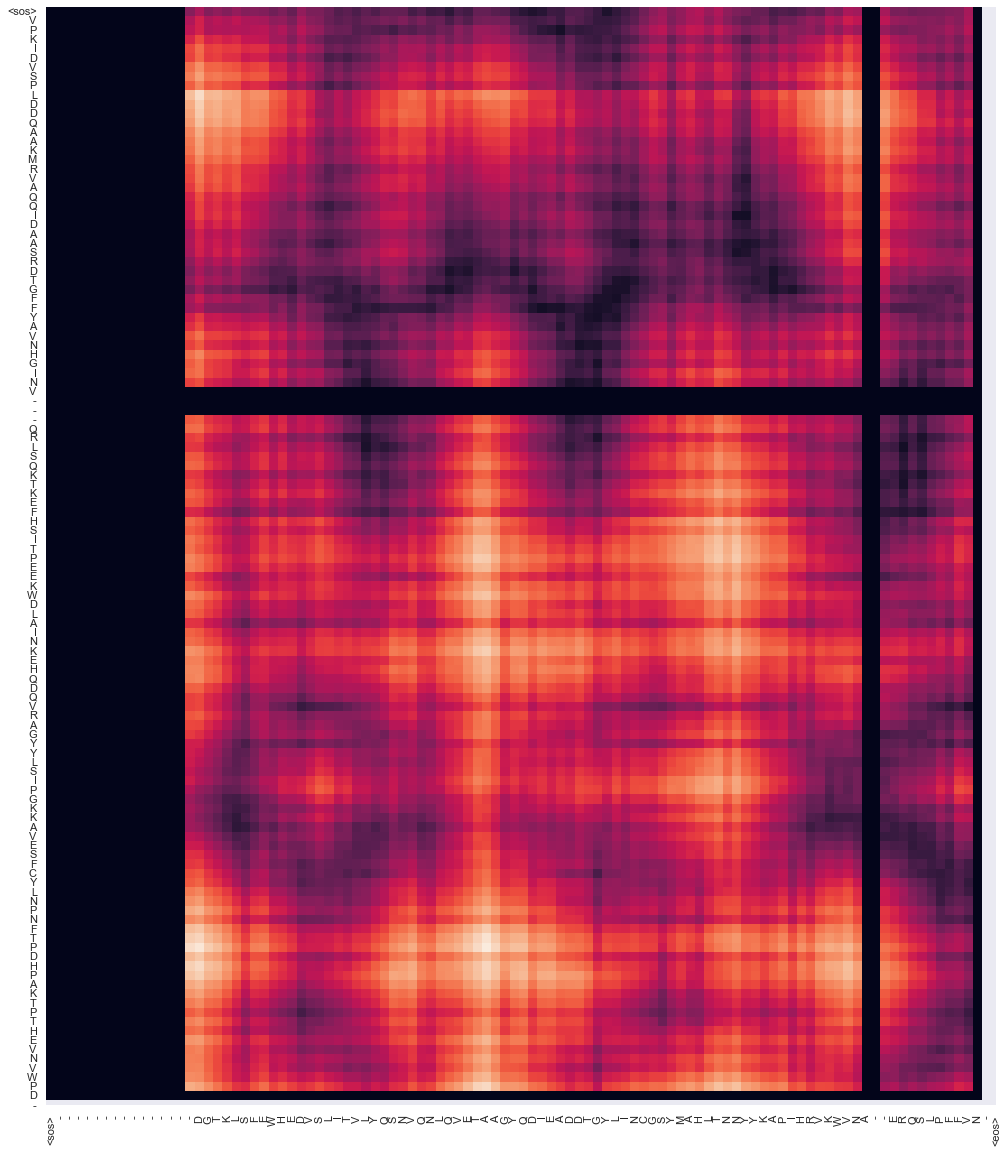

In [171]:
seaborn.heatmap(distMatrix, 
                xticklabels=inputsequence, square=True, yticklabels=targetsequence, vmin=0.0,# vmax=1.0, 
                cbar=False)



In [137]:
pdbin=[]
pdbin[:]= "---------------DGTKLSFEWHEDVSLITVLYQSNVQNLQVETAAGYQDIEADDTGYLINCGSYMAHLTNNYYKAPIHRVKWVNA--ERQSLPFFVN-"
pdbout=[]
pdbout[:]= "VPKIDVSPLDDQAAKMRVAQQIDAASRDTGFFYAVNHGINV---QRLSQKTKEFHSITPEEKWDLAINKEHQDQVRAGYYLSIPGKKAVESFCYLNPNFTPDHPAKTPTHEVNVWPD-"

In [138]:
seqin = [pds.SymbolMap[pds.init_token]]+[pds.SymbolMap[i] for i in pdbin]+[pds.SymbolMap[pds.eos_token]]
seqout = [pds.SymbolMap[pds.init_token]]+[pds.SymbolMap[i] for i in pdbout]+[pds.SymbolMap[pds.eos_token]]

In [139]:
tensorIN[:,i,:] = torch.nn.functional.one_hot(torch.tensor(inp), num_classes=25)
tensorOUT[:,i,:] = torch.nn.functional.one_hot(torch.tensor(out), num_classes=25)

C:\Users\bartm\AppData\Local\Temp/ipykernel_21068/1715144592.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensorIN[:,i,:] = torch.nn.functional.one_hot(torch.tensor(inp), num_classes=25)


RuntimeError: one_hot is only applicable to index tensor.

In [152]:
inp1o = torch.nn.functional.one_hot(torch.tensor(seqin), num_classes=25).unsqueeze(1).to(pds.device)
targ1o = torch.nn.functional.one_hot(torch.tensor(seqout), num_classes=25).unsqueeze(1).to(pds.device)

In [18]:
inp1o

tensor([[[0, 0, 0,  ..., 1, 0, 0]],

        [[1, 0, 0,  ..., 0, 0, 0]],

        [[1, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0]],

        [[1, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 1, 0]]], device='cuda:0')

In [113]:
pds.SymbolMap

{'-': 0,
 'A': 1,
 'C': 2,
 'D': 3,
 'E': 4,
 'F': 5,
 'G': 6,
 'H': 7,
 'I': 8,
 'K': 9,
 'L': 10,
 'M': 11,
 'N': 12,
 'P': 13,
 'Q': 14,
 'R': 15,
 'S': 16,
 'T': 17,
 'V': 18,
 'W': 19,
 'Y': 20,
 '<sos>': 22,
 '<eos>': 23,
 '<pad>': 24}

In [141]:
output = model(inp1o, targ1o[:-1, :])
output = model2(inp1o, targ1o[:-1, :])
output = model3(inp1o, targ1o[:-1, :])

_, o =torch.max(inp1o, dim=2)
inv_map = {v: k for k, v in pds.SymbolMap.items()}
inputsequence = [inv_map[o[i,0].item()] for i in range(o.shape[0])]
_, ot =torch.max(targ1o[:-1, :], dim=2)
targetsequence = [inv_map[ot[i,0].item()] for i in range(ot.shape[0])]

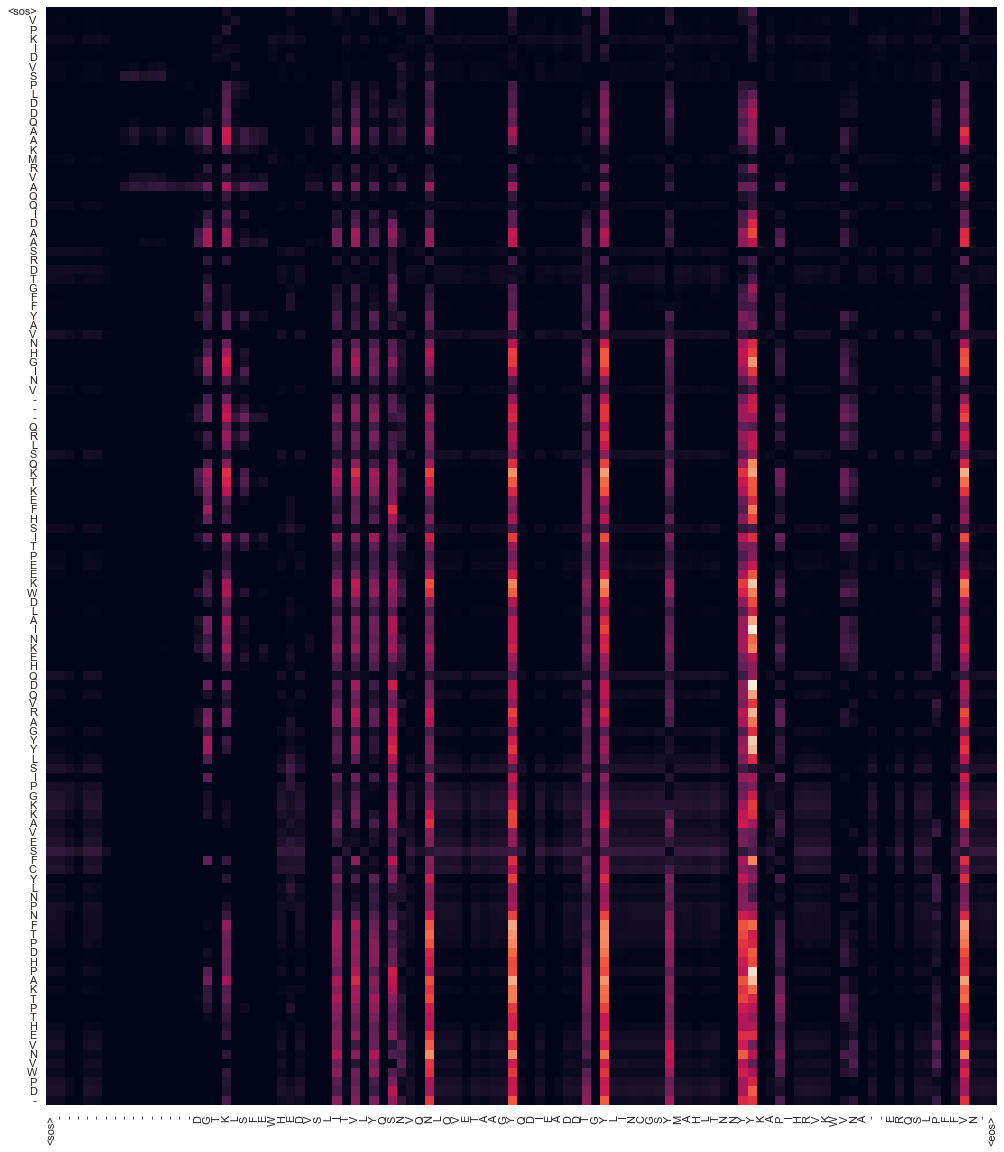

In [28]:
draw(model.transformer.decoder.layers[0].savedAttention.cpu().detach().numpy()[0,:,:]-att,inputsequence, targetsequence )

In [30]:
att[:-1,1:-1].flatten().shape

(11918,)

C:\Users\bartm\Anaconda3\envs\PyT\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

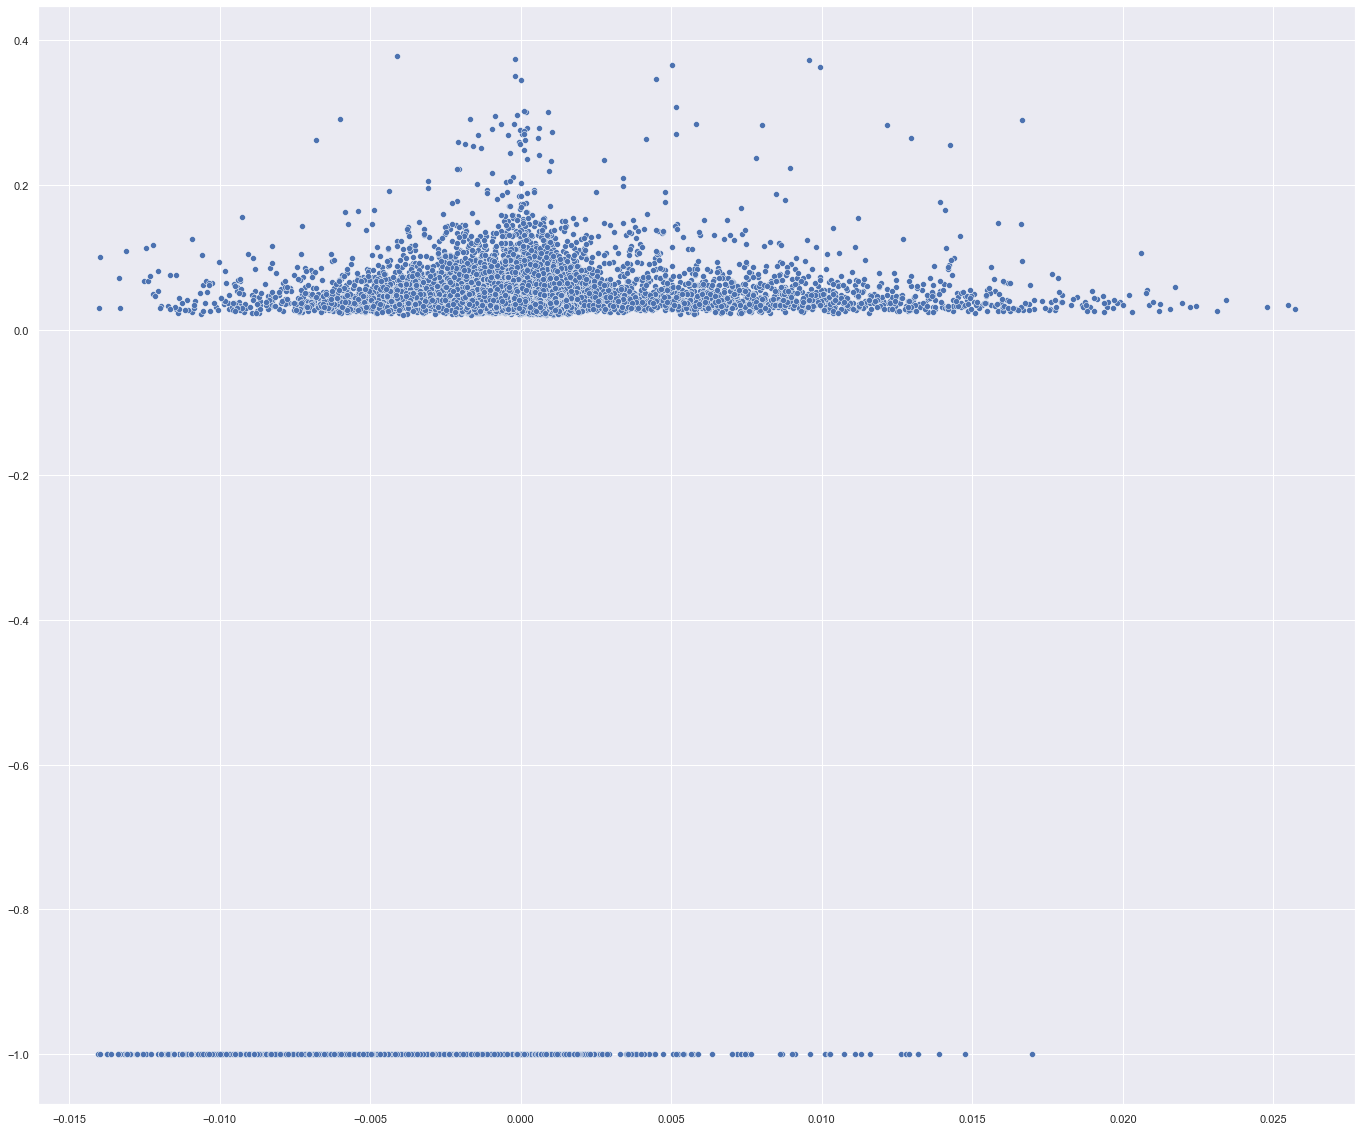

In [33]:
seaborn.scatterplot(model.transformer.decoder.layers[0].savedAttention.cpu().detach().numpy()[0,:-1,1:-1].flatten() - att[:-1,1:-1].flatten(), 1.0/distMatrix.flatten())

In [ ]:
draw(model.transformer.decoder.layers[0].savedAttention.cpu().detach().numpy()[0,:,:],inputsequence, targetsequence )

In [325]:
invdist = distMatrix.flatten()
tokeep = invdist != -1.0
invdist = invdist[tokeep]
attention = att[:-1,1:-1].flatten()[tokeep]

C:\Users\bartm\Anaconda3\envs\PyT\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


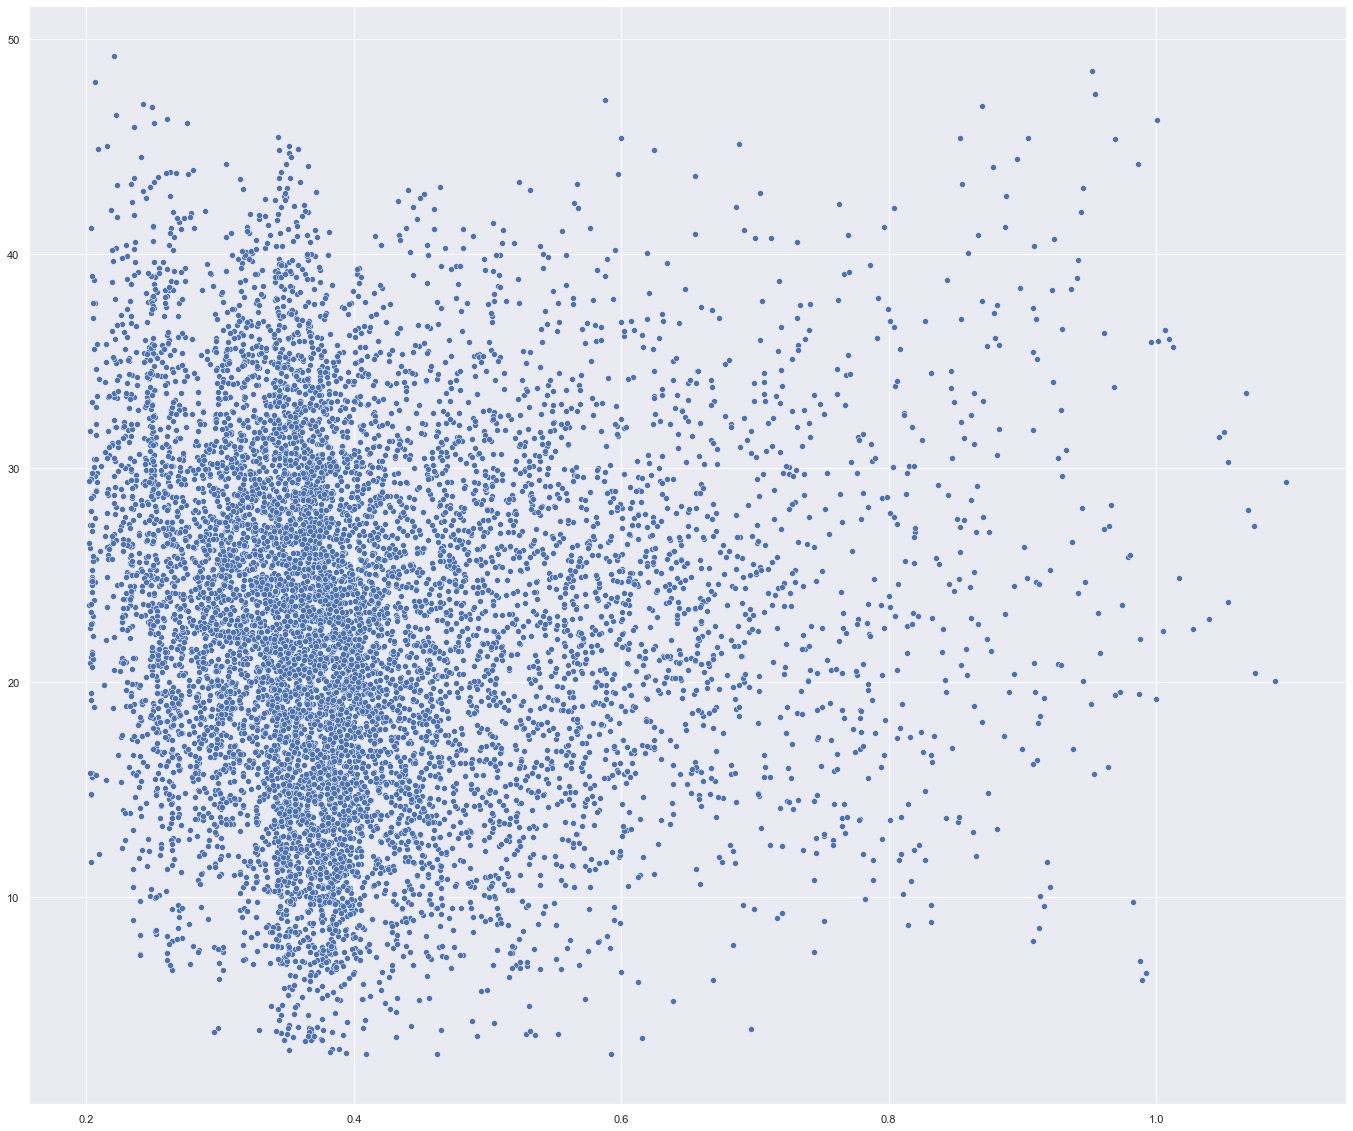

In [326]:
sc1 = seaborn.scatterplot(attention, invdist)

In [206]:
distMatrix.shape

(118, 101)

In [275]:
model3.transformer.decoder.layers[0].savedAttention.cpu().detach().numpy()[0,:-1,1:-1].shape

(118, 101)

In [13]:
val_iterator = DataLoader(pds, batch_size=32,
                        shuffle=True, num_workers=0, collate_fn=default_collate)
criterion = nn.CrossEntropyLoss(ignore_index=pds.SymbolMap["<pad>"])

In [16]:
# att = model.transformer.decoder.layers[0].savedAttention.cpu().detach().numpy()[0,:,:]
model.eval()
losses_eval = []
count = 0
with  torch.no_grad():
    for batch_idx, batch in enumerate(val_iterator):
        count+=1
        inp_data, target= batch[0], batch[1]
        print("1",inp_data.shape, target.shape)
        inp_data = inp_data.to(device)
        output = model(inp_data, target[:-1, :])
        print("1",output.shape)
        output = output.reshape(-1, output.shape[2]) #keep last dimension
         print("1",output.shape)
        _, targets_Original = target.max(dim=2)
         print("1",output.shape)
        targets_Original = targets_Original[1:].reshape(-1)
        print("1",output.shape, targets_Original.shape)
        loss_eval = criterion(output, targets_Original)
        losses_eval.append(loss_eval.item())
#         att += model.transformer.decoder.layers[0].savedAttention.cpu().detach().numpy()[0,:,:]
mean_lossVal = sum(losses_eval) / len(losses_eval)
att /=count

torch.Size([103, 32, 25]) torch.Size([120, 32, 25])
torch.Size([119, 32, 25])
torch.Size([3808, 25]) torch.Size([3808])
torch.Size([103, 32, 25]) torch.Size([120, 32, 25])
torch.Size([119, 32, 25])
torch.Size([3808, 25]) torch.Size([3808])
torch.Size([103, 32, 25]) torch.Size([120, 32, 25])
torch.Size([119, 32, 25])
torch.Size([3808, 25]) torch.Size([3808])
torch.Size([103, 32, 25]) torch.Size([120, 32, 25])
torch.Size([119, 32, 25])
torch.Size([3808, 25]) torch.Size([3808])
torch.Size([103, 32, 25]) torch.Size([120, 32, 25])
torch.Size([119, 32, 25])
torch.Size([3808, 25]) torch.Size([3808])
torch.Size([103, 32, 25]) torch.Size([120, 32, 25])
torch.Size([119, 32, 25])
torch.Size([3808, 25]) torch.Size([3808])
torch.Size([103, 32, 25]) torch.Size([120, 32, 25])
torch.Size([119, 32, 25])
torch.Size([3808, 25]) torch.Size([3808])
torch.Size([103, 32, 25]) torch.Size([120, 32, 25])
torch.Size([119, 32, 25])
torch.Size([3808, 25]) torch.Size([3808])
torch.Size([103, 32, 25]) torch.Size([12

NameError: name 'att' is not defined

In [22]:
mean_lossVal

0.8037604218305543

In [83]:

load_checkpoint(torch.load("fam17Pos.pth.tar"), model, optimizer)
model.eval()
output = model(inp1o, targ1o[:-1, :])
output = output.reshape(-1, output.shape[2]) #keep last dimension
_, targets_Original = targ1o.max(dim=2)
targets_Original = targets_Original[1:].reshape(-1)
loss_eval = criterion(output, targets_Original)
loss_eval

=> Loading checkpoint


RuntimeError: Error(s) in loading state_dict for Transformer:
	Missing key(s) in state_dict: "transformer.encoder.layers.4.self_attn.in_proj_weight", "transformer.encoder.layers.4.self_attn.in_proj_bias", "transformer.encoder.layers.4.self_attn.out_proj.weight", "transformer.encoder.layers.4.self_attn.out_proj.bias", "transformer.encoder.layers.4.linear1.weight", "transformer.encoder.layers.4.linear1.bias", "transformer.encoder.layers.4.linear2.weight", "transformer.encoder.layers.4.linear2.bias", "transformer.encoder.layers.4.norm1.weight", "transformer.encoder.layers.4.norm1.bias", "transformer.encoder.layers.4.norm2.weight", "transformer.encoder.layers.4.norm2.bias", "transformer.encoder.layers.5.self_attn.in_proj_weight", "transformer.encoder.layers.5.self_attn.in_proj_bias", "transformer.encoder.layers.5.self_attn.out_proj.weight", "transformer.encoder.layers.5.self_attn.out_proj.bias", "transformer.encoder.layers.5.linear1.weight", "transformer.encoder.layers.5.linear1.bias", "transformer.encoder.layers.5.linear2.weight", "transformer.encoder.layers.5.linear2.bias", "transformer.encoder.layers.5.norm1.weight", "transformer.encoder.layers.5.norm1.bias", "transformer.encoder.layers.5.norm2.weight", "transformer.encoder.layers.5.norm2.bias", "transformer.decoder.layers.4.self_attn.in_proj_weight", "transformer.decoder.layers.4.self_attn.in_proj_bias", "transformer.decoder.layers.4.self_attn.out_proj.weight", "transformer.decoder.layers.4.self_attn.out_proj.bias", "transformer.decoder.layers.4.multihead_attn.in_proj_weight", "transformer.decoder.layers.4.multihead_attn.in_proj_bias", "transformer.decoder.layers.4.multihead_attn.out_proj.weight", "transformer.decoder.layers.4.multihead_attn.out_proj.bias", "transformer.decoder.layers.4.linear1.weight", "transformer.decoder.layers.4.linear1.bias", "transformer.decoder.layers.4.linear2.weight", "transformer.decoder.layers.4.linear2.bias", "transformer.decoder.layers.4.norm1.weight", "transformer.decoder.layers.4.norm1.bias", "transformer.decoder.layers.4.norm2.weight", "transformer.decoder.layers.4.norm2.bias", "transformer.decoder.layers.4.norm3.weight", "transformer.decoder.layers.4.norm3.bias", "transformer.decoder.layers.5.self_attn.in_proj_weight", "transformer.decoder.layers.5.self_attn.in_proj_bias", "transformer.decoder.layers.5.self_attn.out_proj.weight", "transformer.decoder.layers.5.self_attn.out_proj.bias", "transformer.decoder.layers.5.multihead_attn.in_proj_weight", "transformer.decoder.layers.5.multihead_attn.in_proj_bias", "transformer.decoder.layers.5.multihead_attn.out_proj.weight", "transformer.decoder.layers.5.multihead_attn.out_proj.bias", "transformer.decoder.layers.5.linear1.weight", "transformer.decoder.layers.5.linear1.bias", "transformer.decoder.layers.5.linear2.weight", "transformer.decoder.layers.5.linear2.bias", "transformer.decoder.layers.5.norm1.weight", "transformer.decoder.layers.5.norm1.bias", "transformer.decoder.layers.5.norm2.weight", "transformer.decoder.layers.5.norm2.bias", "transformer.decoder.layers.5.norm3.weight", "transformer.decoder.layers.5.norm3.bias". 
	size mismatch for src_position_embedding.pe: copying a param with shape torch.Size([103, 1, 25]) from checkpoint, the shape in current model is torch.Size([66, 1, 25]).
	size mismatch for trg_position_embedding.pe: copying a param with shape torch.Size([120, 1, 25]) from checkpoint, the shape in current model is torch.Size([114, 1, 25]).
	size mismatch for transformer.encoder.layers.0.linear1.weight: copying a param with shape torch.Size([4096, 25]) from checkpoint, the shape in current model is torch.Size([2048, 25]).
	size mismatch for transformer.encoder.layers.0.linear1.bias: copying a param with shape torch.Size([4096]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for transformer.encoder.layers.0.linear2.weight: copying a param with shape torch.Size([25, 4096]) from checkpoint, the shape in current model is torch.Size([25, 2048]).
	size mismatch for transformer.encoder.layers.1.linear1.weight: copying a param with shape torch.Size([4096, 25]) from checkpoint, the shape in current model is torch.Size([2048, 25]).
	size mismatch for transformer.encoder.layers.1.linear1.bias: copying a param with shape torch.Size([4096]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for transformer.encoder.layers.1.linear2.weight: copying a param with shape torch.Size([25, 4096]) from checkpoint, the shape in current model is torch.Size([25, 2048]).
	size mismatch for transformer.encoder.layers.2.linear1.weight: copying a param with shape torch.Size([4096, 25]) from checkpoint, the shape in current model is torch.Size([2048, 25]).
	size mismatch for transformer.encoder.layers.2.linear1.bias: copying a param with shape torch.Size([4096]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for transformer.encoder.layers.2.linear2.weight: copying a param with shape torch.Size([25, 4096]) from checkpoint, the shape in current model is torch.Size([25, 2048]).
	size mismatch for transformer.encoder.layers.3.linear1.weight: copying a param with shape torch.Size([4096, 25]) from checkpoint, the shape in current model is torch.Size([2048, 25]).
	size mismatch for transformer.encoder.layers.3.linear1.bias: copying a param with shape torch.Size([4096]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for transformer.encoder.layers.3.linear2.weight: copying a param with shape torch.Size([25, 4096]) from checkpoint, the shape in current model is torch.Size([25, 2048]).
	size mismatch for transformer.decoder.layers.0.linear1.weight: copying a param with shape torch.Size([4096, 25]) from checkpoint, the shape in current model is torch.Size([2048, 25]).
	size mismatch for transformer.decoder.layers.0.linear1.bias: copying a param with shape torch.Size([4096]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for transformer.decoder.layers.0.linear2.weight: copying a param with shape torch.Size([25, 4096]) from checkpoint, the shape in current model is torch.Size([25, 2048]).
	size mismatch for transformer.decoder.layers.1.linear1.weight: copying a param with shape torch.Size([4096, 25]) from checkpoint, the shape in current model is torch.Size([2048, 25]).
	size mismatch for transformer.decoder.layers.1.linear1.bias: copying a param with shape torch.Size([4096]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for transformer.decoder.layers.1.linear2.weight: copying a param with shape torch.Size([25, 4096]) from checkpoint, the shape in current model is torch.Size([25, 2048]).
	size mismatch for transformer.decoder.layers.2.linear1.weight: copying a param with shape torch.Size([4096, 25]) from checkpoint, the shape in current model is torch.Size([2048, 25]).
	size mismatch for transformer.decoder.layers.2.linear1.bias: copying a param with shape torch.Size([4096]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for transformer.decoder.layers.2.linear2.weight: copying a param with shape torch.Size([25, 4096]) from checkpoint, the shape in current model is torch.Size([25, 2048]).
	size mismatch for transformer.decoder.layers.3.linear1.weight: copying a param with shape torch.Size([4096, 25]) from checkpoint, the shape in current model is torch.Size([2048, 25]).
	size mismatch for transformer.decoder.layers.3.linear1.bias: copying a param with shape torch.Size([4096]) from checkpoint, the shape in current model is torch.Size([2048]).
	size mismatch for transformer.decoder.layers.3.linear2.weight: copying a param with shape torch.Size([25, 4096]) from checkpoint, the shape in current model is torch.Size([25, 2048]).

In [336]:
output = model(inp1o, targ1o[:-1, :])
print(output.shape)
output = output.reshape(-1, output.shape[2])
print(output.shape)

print(targ1o.shape)
_, targets_Original = targ1o.max(dim=2)
print(targets_Original.shape)
torch.nn.functional.one_hot(targets_Original, num_classes=25)
torch.nn.functional.softmax(output, dim=1)[1,:]

torch.Size([119, 1, 25])
torch.Size([119, 25])
torch.Size([120, 1, 25])
torch.Size([120, 1])


tensor([1.1778e-06, 2.4684e-05, 1.5052e-07, 6.8223e-06, 7.4740e-07, 1.3726e-07,
        5.5535e-06, 1.5071e-07, 1.0682e-08, 8.9915e-06, 1.1199e-06, 4.0990e-08,
        1.9003e-07, 9.9993e-01, 4.5107e-07, 7.3476e-06, 7.2146e-06, 1.7218e-06,
        1.2839e-06, 2.2961e-07, 2.1599e-07, 4.1893e-12, 3.9240e-12, 4.1641e-09,
        4.2013e-12], device='cuda:0', grad_fn=<SliceBackward>)

In [338]:
output.clone().detach()

tensor([[  2.2231,   2.3256,  -3.5611,  ..., -21.9034, -12.7306, -21.8872],
        [ -0.7469,   2.2956,  -2.8042,  ..., -13.3589,  -6.3918, -13.2906],
        [ -5.4124,   1.2437,  -1.4724,  ..., -16.4780, -11.1440, -16.4655],
        ...,
        [  2.7558,   1.0455,  -4.9239,  ..., -16.4528,  -8.8042, -16.4268],
        [  6.2763,  -1.1213,  -4.4761,  ..., -16.6577,  -1.0616, -16.5997],
        [  7.1963,  -2.7746,  -0.7415,  ..., -12.8793,  21.1649, -12.7922]],
       device='cuda:0')

In [271]:
model.transformer.decoder.layers[0].savedAttention

tensor([[[0.0076, 0.0070, 0.0110,  ..., 0.0158, 0.0078, 0.0083],
         [0.0082, 0.0099, 0.0038,  ..., 0.0107, 0.0075, 0.0127],
         [0.0081, 0.0064, 0.0138,  ..., 0.0091, 0.0160, 0.0125],
         ...,
         [0.0030, 0.0081, 0.0238,  ..., 0.0066, 0.0100, 0.0088],
         [0.0040, 0.0046, 0.0123,  ..., 0.0040, 0.0091, 0.0104],
         [0.0023, 0.0055, 0.0084,  ..., 0.0047, 0.0055, 0.0075]]],
       device='cuda:0', grad_fn=<DivBackward0>)

In [ ]:
hm1 = seaborn.heatmap(model.transformer.decoder.layers[0].savedAttention.cpu().detach().numpy()[0,:,:], 
                xticklabels=inputsequence, square=True, yticklabels=targetsequence, vmin=0.0,# vmax=1.0, 
                cbar=False)

In [ ]:
draw(model.transformer.decoder.layers[0].savedAttention.cpu().detach().numpy()[0,:,:]

In [28]:
attention = model.transformer.decoder.layers[0].savedAttention.cpu().detach().numpy()[0,:,:]
np.sum(attention, axis=1).shape

(119,)

In [300]:
inp1o.shape

torch.Size([103, 1, 25])

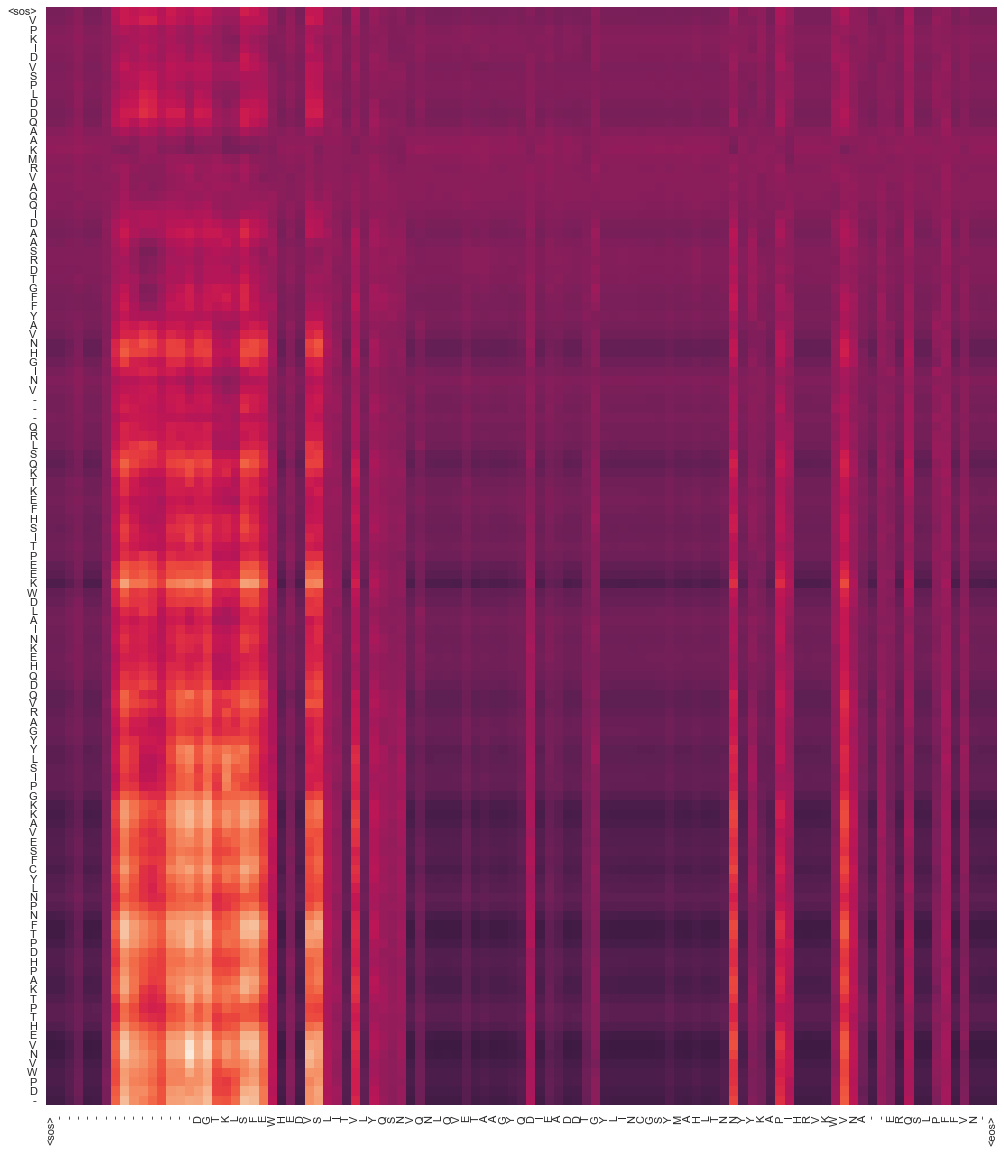

In [24]:
draw(att,inputsequence, targetsequence )

In [25]:
att

array([[0.00864711, 0.00864588, 0.00897668, ..., 0.00867806, 0.00866658,
        0.00866771],
       [0.00873677, 0.00873213, 0.00919602, ..., 0.00880778, 0.00880276,
        0.00881973],
       [0.00929653, 0.00929059, 0.00947949, ..., 0.00935939, 0.00936186,
        0.00937654],
       ...,
       [0.00559586, 0.0055988 , 0.00655394, ..., 0.00561278, 0.00558789,
        0.00557473],
       [0.00521526, 0.00521927, 0.00636982, ..., 0.00526828, 0.00522438,
        0.00521201],
       [0.0049897 , 0.00499812, 0.00610408, ..., 0.00499891, 0.00496375,
        0.00494856]], dtype=float32)

In [ ]:
-att

In [66]:
def Apc(Att):
    #Average Product Correction which improves contact Predictions
    Attip = np.mean(Att, axis=1)
    Attpj = np.mean(Att, axis=0)
    Attpp = np.mean(Attpj)
    AttAPC = np.zeros(Att.shape)
    for i in range(Att.shape[0]):
        for j in range(Att.shape[1]):
            AttAPC[i,j] = Att[i,j] + (Attip[i]*Attpj[j])/Attpp
        
    return AttAPC     

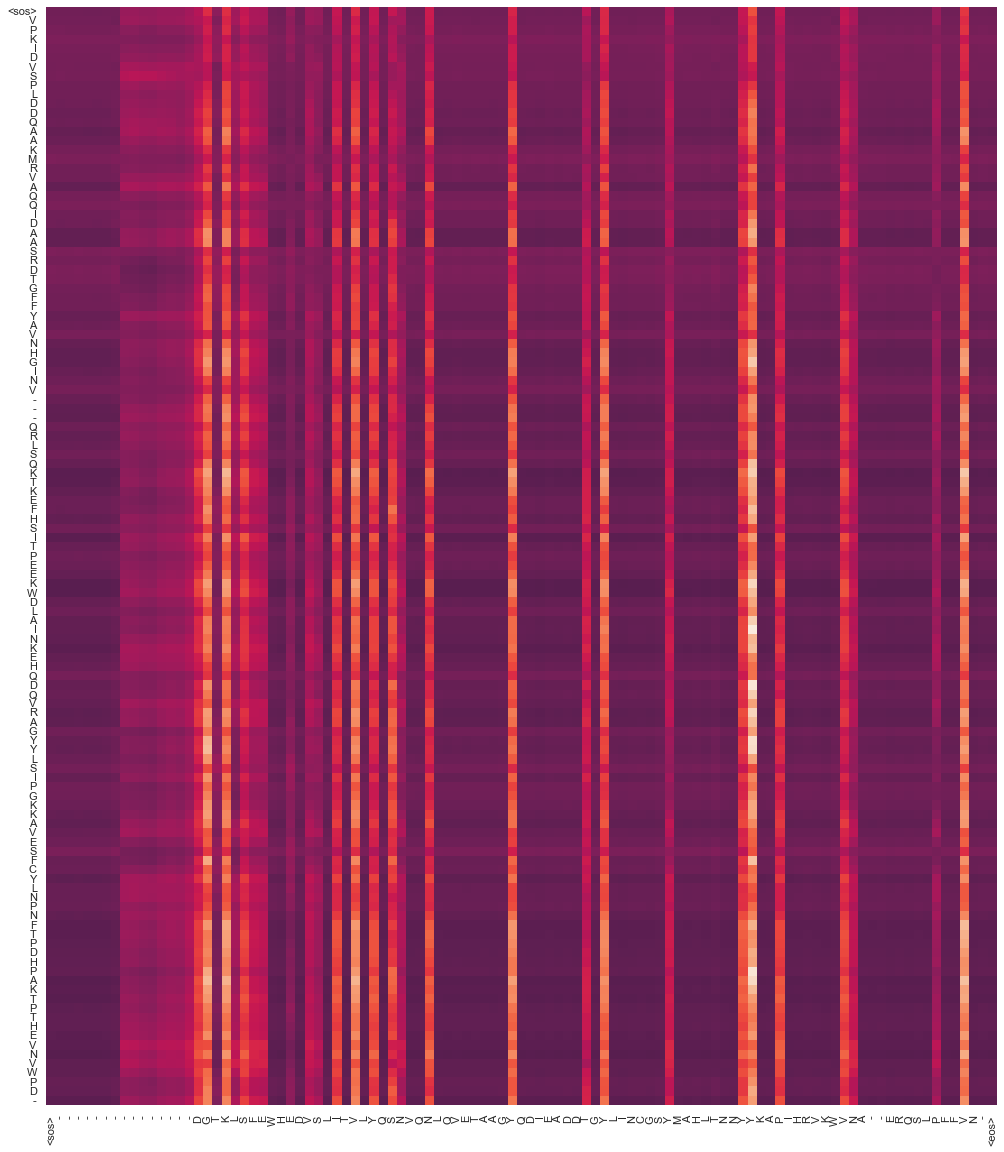

In [42]:
draw(Apc(model.transformer.decoder.layers[0].savedAttention.cpu().detach().numpy()[0,:,:]),inputsequence, targetsequence )

In [59]:
invdist = distMatrix.flatten()
tokeep = invdist != -1.0
# invdist = invdist[tokeep]
attention = Apc(model.transformer.decoder.layers[0].savedAttention.cpu().detach().numpy()[0,:,:])[:-1,1:-1].flatten()[tokeep]
attention = Apc(att)[:-1,1:-1].flatten()

<AxesSubplot:>

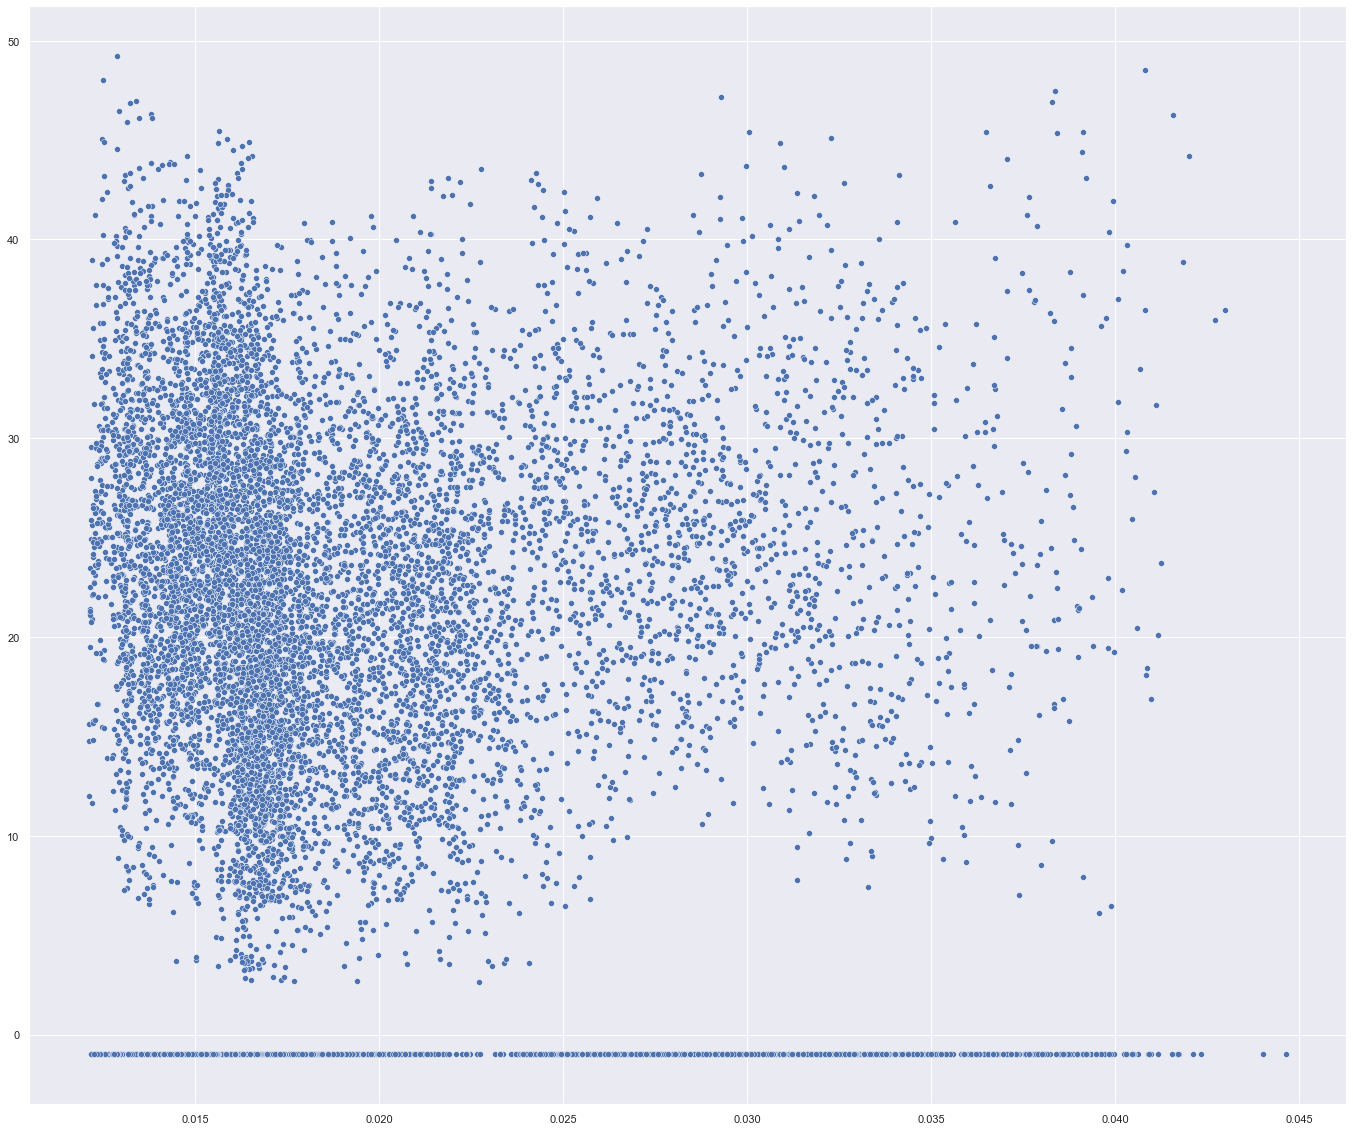

In [60]:
seaborn.scatterplot(attention, invdist)

# Unaligned


In [105]:
import matplotlib.pyplot as plt

In [97]:
pdbin=[]
pdbin[:]= "DGTKLSFEWHEDVSLITVLYQSNVQNLQVETAAGYQDIEADDTGYLINCGSYMAHLTNNYYKAPIHRVKWVNAERQSLPFFVN"
pdbout=[]
pdbout[:]= "VPKIDVSPLDDQAAKMRVAQQIDAASRDTGFFYAVNHGINVQRLSQKTKEFHSITPEEKWDLAINKEHQDQVRAGYYLSIPGKKAVESFCYLNPNFTPDHPAKTPTHEVNVWPD"

seqin = [pds.SymbolMap[pds.init_token]]+[pds.SymbolMap[i] for i in pdbin]+[pds.SymbolMap[pds.eos_token]]
seqout = [pds.SymbolMap[pds.init_token]]+[pds.SymbolMap[i] for i in pdbout]+[pds.SymbolMap[pds.eos_token]]

seqin += [pds.SymbolMap[pds.pad_token]]*(pds.inputsize - len(seqin))
seqout += [pds.SymbolMap[pds.pad_token]]*(pds.outputsize - len(seqout))

inp1o = torch.nn.functional.one_hot(torch.tensor(seqin), num_classes=25).unsqueeze(1).to(pds.device)
targ1o = torch.nn.functional.one_hot(torch.tensor(seqout), num_classes=25).unsqueeze(1).to(pds.device)

_, o =torch.max(inp1o, dim=2)
inv_map = {v: k for k, v in pds.SymbolMap.items()}
inputsequence = [inv_map[o[i,0].item()] for i in range(o.shape[0])]
_, ot =torch.max(targ1o[:-1, :], dim=2)
targetsequence = [inv_map[ot[i,0].item()] for i in range(ot.shape[0])]

In [57]:
len_input = 103
len_output = 120
embedding_size = 25
datasetPath = "combined_MSA_ddi_17_joined_test.csv"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pds = ProteinTranslationDataset(datasetPath, device=device, Unalign=True)
src_pad_idx = pds.SymbolMap["<pad>"]

val_iterator = DataLoader(pds, batch_size=32,
                        shuffle=True, num_workers=0, collate_fn=default_collate)
criterion = nn.CrossEntropyLoss(ignore_index=pds.SymbolMap["<pad>"])

num_heads = 5
num_encoder_layers = 6
num_decoder_layers = 6
dropout = 0.10
forward_expansion = 4096
src_vocab_size = 25
trg_vocab_size = 25
src_position_embedding = PositionalEncoding(embedding_size, max_len=len_input,device=device)
trg_position_embedding = PositionalEncoding(embedding_size, max_len=len_output, device=device)

model = Transformer(
    embedding_size,
    src_vocab_size,
    trg_vocab_size,
    src_pad_idx,
    num_heads,
    num_encoder_layers,
    num_decoder_layers,
    forward_expansion,
    dropout,
    src_position_embedding,
    trg_position_embedding,
    device,
).to(device)


Unaligning and Padding
cuda:0
cuda:0


In [58]:
nlayer = len(model.transformer.decoder.layers)
for i in range(nlayer):
    model.transformer.decoder.layers[i].saveAttention = True

In [98]:
output = model(inp1o, targ1o[:-1, :])

In [63]:
load_checkpoint(torch.load("fam17Unalign.pth.tar"), model, optimizer)
model.eval()
output = model(inp1o, targ1o[:-1, :])
output = output.reshape(-1, output.shape[2]) #keep last dimension
_, targets_Original = targ1o.max(dim=2)
targets_Original = targets_Original[1:].reshape(-1)
loss_eval = criterion(output, targets_Original)
loss_eval

=> Loading checkpoint


tensor(2.2055, device='cuda:0', grad_fn=<NllLossBackward>)

In [147]:
att = np.zeros(model.transformer.decoder.layers[3].savedAttention.cpu().detach().numpy()[0,:,:].shape)
model.eval()
losses_eval = []
count = 0
with  torch.no_grad():
    for batch_idx, batch in enumerate(val_iterator):
        count+=1
        inp_data, target= batch[0], batch[1]
        print(inp_data.device)
        inp_data = inp_data.to(device)
        print(inp_data.device)
        output = model(inp_data, target[:-1, :])
        output = output.reshape(-1, output.shape[2]) #keep last dimension
        _, targets_Original = target.max(dim=2)
        targets_Original = targets_Original[1:].reshape(-1)
        loss_eval = criterion(output, targets_Original)
        losses_eval.append(loss_eval.item())
        att += model.transformer.decoder.layers[3].savedAttention.cpu().detach().numpy()[0,:,:]
mean_lossVal = sum(losses_eval) / len(losses_eval)
att /=count

AttributeError: 'NoneType' object has no attribute 'cpu'

In [61]:
mean_lossVal

1.0741349722063818

In [39]:
checkpoint = torch.load("fam17Unalign.pth.tar")

In [46]:
a = checkpoint['state_dict'].keys()

In [47]:
b = model.state_dict().keys()

In [50]:
for pa in b:
    if pa in a:
        print(pa)

src_position_embedding.pe
trg_position_embedding.pe
transformer.encoder.layers.0.self_attn.in_proj_weight
transformer.encoder.layers.0.self_attn.in_proj_bias
transformer.encoder.layers.0.self_attn.out_proj.weight
transformer.encoder.layers.0.self_attn.out_proj.bias
transformer.encoder.layers.0.linear1.weight
transformer.encoder.layers.0.linear1.bias
transformer.encoder.layers.0.linear2.weight
transformer.encoder.layers.0.linear2.bias
transformer.encoder.layers.0.norm1.weight
transformer.encoder.layers.0.norm1.bias
transformer.encoder.layers.0.norm2.weight
transformer.encoder.layers.0.norm2.bias
transformer.encoder.layers.1.self_attn.in_proj_weight
transformer.encoder.layers.1.self_attn.in_proj_bias
transformer.encoder.layers.1.self_attn.out_proj.weight
transformer.encoder.layers.1.self_attn.out_proj.bias
transformer.encoder.layers.1.linear1.weight
transformer.encoder.layers.1.linear1.bias
transformer.encoder.layers.1.linear2.weight
transformer.encoder.layers.1.linear2.bias
transformer.

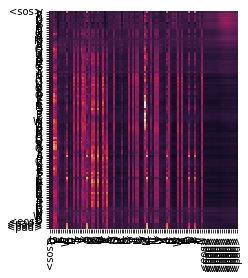

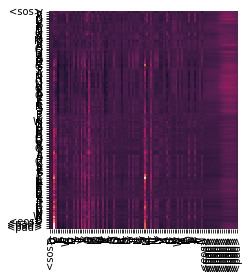

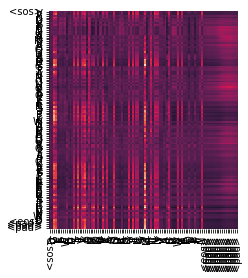

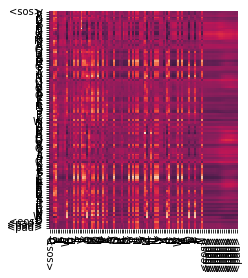

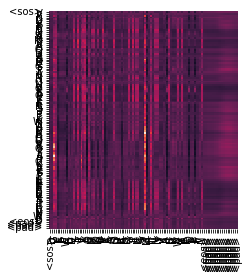

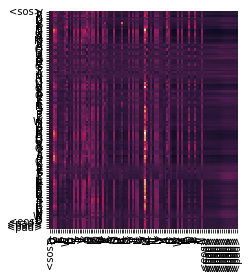

In [106]:
for i in range(6):
    draw(model.transformer.decoder.layers[i].savedAttention.cpu().detach().numpy()[0,:,:],inputsequence, targetsequence )
    plt.show()

(119, 103)

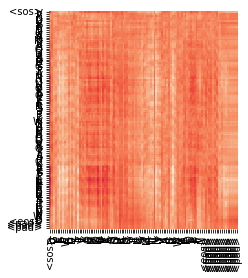

In [112]:
draw(att,inputsequence, targetsequence )
att.shape

In [73]:
pdbin=[]
pdbin[:]= "---------------DGTKLSFEWHEDVSLITVLYQSNVQNLQVETAAGYQDIEADDTGYLINCGSYMAHLTNNYYKAPIHRVKWVNA--ERQSLPFFVN-"
pdbout=[]
pdbout[:]= "VPKIDVSPLDDQAAKMRVAQQIDAASRDTGFFYAVNHGINV---QRLSQKTKEFHSITPEEKWDLAINKEHQDQVRAGYYLSIPGKKAVESFCYLNPNFTPDHPAKTPTHEVNVWPD-"

In [79]:
filterin = list(map(lambda x: x!='-', pdbin))
filterout = list(map(lambda x: x!='-', pdbout))

In [86]:
print(len(filterout))
distMatrix.shape

118


(118, 101)

In [91]:
distMatrix[filterout,:][:,filterin].shape

(114, 83)

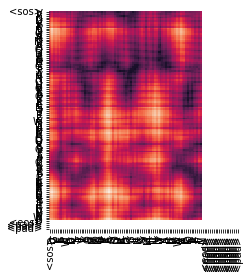

In [92]:
draw(distMatrix[filterout,:][:,filterin],inputsequence, targetsequence )

# HK-RR

In [112]:
len_input = 66
len_output = 114
embedding_size = 25
datasetPath = "test_real.csv"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pds = ProteinTranslationDataset(datasetPath, device=device, Unalign=False)
src_pad_idx = pds.SymbolMap["<pad>"]

val_iterator = DataLoader(pds, batch_size=10,
                        shuffle=True, num_workers=0, collate_fn=default_collate)
criterion = nn.CrossEntropyLoss(ignore_index=pds.SymbolMap["<pad>"])

num_heads = 5
num_encoder_layers = 6
num_decoder_layers = 6
dropout = 0.10
forward_expansion = 2048
src_vocab_size = 25
trg_vocab_size = 25
src_position_embedding = PositionalEncoding(embedding_size, max_len=len_input,device=device)
trg_position_embedding = PositionalEncoding(embedding_size, max_len=len_output, device=device)

model = Transformer(
    embedding_size,
    src_vocab_size,
    trg_vocab_size,
    src_pad_idx,
    num_heads,
    num_encoder_layers,
    num_decoder_layers,
    forward_expansion,
    dropout,
    src_position_embedding,
    trg_position_embedding,
    device,
).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

keeping the gap
cuda:0
cuda:0


In [103]:
nlayer = len(model.transformer.decoder.layers)
for i in range(nlayer):
    model.transformer.decoder.layers[i].saveAttention = True

In [116]:
load_checkpoint(torch.load("famHkRR_pos_O.pth.tar"), model, optimizer)
model.eval()
inp, tar = next(iter(val_iterator))
output = model(inp, tar[:-1, :])
output = output.reshape(-1, output.shape[2]) #keep last dimension
_, targets_Original = targ1o.max(dim=2)
targets_Original = targets_Original[1:].reshape(-1)
loss_eval = criterion(output, targets_Original)
loss_eval

=> Loading checkpoint


ValueError: Expected input batch_size (1130) to match target batch_size (119).

In [106]:
att = np.zeros(model.transformer.decoder.layers[5].savedAttention.cpu().detach().numpy()[0,:,:].shape)
model.eval()
losses_eval = []
count = 0
with  torch.no_grad():
    for batch_idx, batch in enumerate(val_iterator):
        count+=1
        inp_data, target= batch[0], batch[1]
        print(inp_data.device)
        inp_data = inp_data.to(device)
        print(inp_data.device)
        output = model(inp_data, target[:-1, :])
        output = output.reshape(-1, output.shape[2]) #keep last dimension
        _, targets_Original = target.max(dim=2)
        targets_Original = targets_Original[1:].reshape(-1)
        loss_eval = criterion(output, targets_Original)
        losses_eval.append(loss_eval.item())
        att += model.transformer.decoder.layers[5].savedAttention.cpu().detach().numpy()[0,:,:]
mean_lossVal = sum(losses_eval) / len(losses_eval)
att /=count

cuda:0
cuda:0


ValueError: only one element tensors can be converted to Python scalars

In [126]:
def makesquaredLoss(batch, model, criterion, criterionMatching, device):
    inp_data, target= batch[0], batch[1]
    bs = inp_data.shape[1]
    lossMatrix = torch.zeros((bs,bs)).to(device)
    LossCE = torch.tensor(0.0).to(device)
    for i in range(bs):
        inp_repeted = inp_data[:,i,:].unsqueeze(1).repeat(1,bs,1)
        # print(i, inp_repeted.shape)
        output = model(inp_repeted, target[:-1, :])
        output = output.reshape(-1, output.shape[2])#keep last dimension
        _, targets_Original = target.max(dim=2)
        targets_Original = targets_Original[1:].reshape(-1)
        loss = criterion(output, targets_Original).reshape(-1,bs).mean(dim=0)
        
        lossMatrix[i,:] = loss
        LossCE += loss[i]
        
    LossCE /=bs
    lossMatrix *=-1
    
    print(lossMatrix)
#    lossMatrix = torch.nn.functional.softmax(lossMatrix, dim=0)
    targetMatching = torch.tensor(range(bs)).to(device)
    lossMatching = criterionMatching(lossMatrix, targetMatching)
    return LossCE, lossMatching






criterion = nn.CrossEntropyLoss(ignore_index=pds.SymbolMap["<pad>"], reduction='none')
criterion2 = nn.CrossEntropyLoss(ignore_index=pds.SymbolMap["<pad>"])
criterionMatching = nn.CrossEntropyLoss()
model.eval()
losses_eval = []
count = 0
with  torch.no_grad():
    batch = next(iter(val_iterator))
    count+=1
    LossCE, lossMatching = makesquaredLoss(batch, model, criterion, criterionMatching, device)
    print(LossCE, lossMatching)
    
    
    inp_data, target= batch[0], batch[1]
    print(inp_data.shape, target.shape)
    inp_data = inp_data.to(device)
    output = model(inp_data, target[:-1, :])
    output = output.reshape(-1, output.shape[2]) #keep last dimension
    print("output", output.shape)
    _, targets_Original = target.max(dim=2)
    targets_Original = targets_Original[1:].reshape(-1)
    loss_eval = criterion2(output, targets_Original)
    print("loss",loss_eval, loss_eval.shape)
#     losses_eval.append(loss_eval.item())

tensor([[-0.4859, -3.7246, -4.4046, -4.5404, -3.7408, -2.5644, -5.3334, -3.8840,
         -5.1276, -3.8821],
        [-4.3443, -0.7697, -5.1451, -5.3211, -5.4146, -4.3843, -6.2908, -5.4577,
         -5.8801, -4.3674],
        [-2.0871, -2.2918, -2.4147, -2.7002, -2.5638, -2.2151, -3.5603, -2.9964,
         -3.2854, -2.1123],
        [-2.7622, -3.1163, -3.2501, -1.4236, -1.9852, -2.3522, -4.1744, -2.8904,
         -3.7328, -3.1152],
        [-1.6981, -2.3978, -2.8469, -2.1533, -1.5765, -1.4874, -3.6591, -2.3403,
         -3.3900, -2.2763],
        [-2.3199, -3.5545, -4.4742, -3.8921, -3.0497, -0.7622, -5.3015, -3.9180,
         -4.7873, -3.6876],
        [-3.0138, -3.1799, -2.9916, -3.7852, -3.5028, -3.4939, -0.8441, -3.4233,
         -2.7471, -3.2509],
        [-2.1455, -2.6920, -3.0435, -2.1276, -2.3777, -2.4045, -3.5732, -1.5931,
         -3.2259, -2.6304],
        [-2.5414, -2.5441, -2.8742, -2.7041, -2.8219, -2.6444, -1.9573, -2.8824,
         -1.6300, -2.5660],
        [-1.7686, -

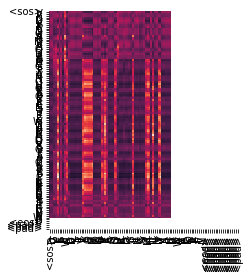

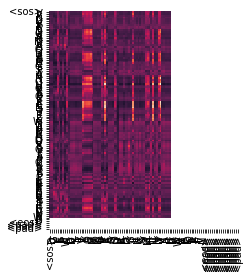

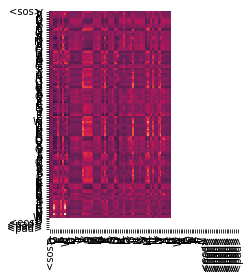

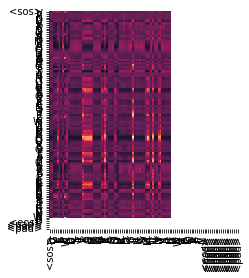

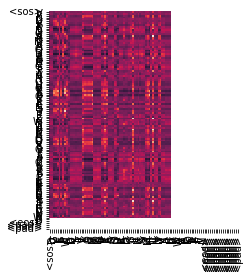

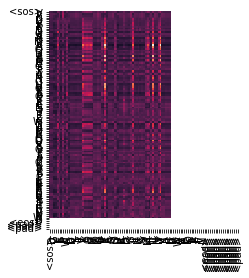

In [120]:
for i in range(6):
    draw(model.transformer.decoder.layers[i].savedAttention.cpu().detach().numpy()[0,:,:],inputsequence, targetsequence )
    plt.show()

<AxesSubplot:>

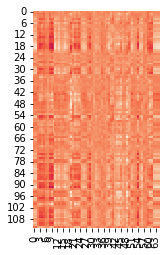

In [122]:
seaborn.heatmap(att, square=True, vmin=0.0, cbar=False)# vmax=1.0,

<AxesSubplot:>

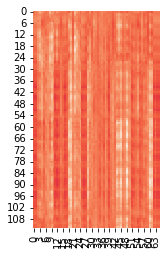

In [124]:
seaborn.heatmap(att, square=True, vmin=0.0, cbar=False)

<AxesSubplot:>

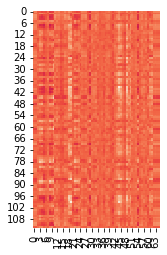

In [128]:
seaborn.heatmap(att, square=True, vmin=0.0, cbar=False)

In [13]:
next(iter(val_iterator))

[tensor([[[0., 0., 0.,  ..., 1., 0., 0.],
          [0., 0., 0.,  ..., 1., 0., 0.],
          [0., 0., 0.,  ..., 1., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 1., 0., 0.],
          [0., 0., 0.,  ..., 1., 0., 0.],
          [0., 0., 0.,  ..., 1., 0., 0.]],
 
         [[1., 0., 0.,  ..., 0., 0., 0.],
          [1., 0., 0.,  ..., 0., 0., 0.],
          [1., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [1., 0., 0.,  ..., 0., 0., 0.],
          [1., 0., 0.,  ..., 0., 0., 0.],
          [1., 0., 0.,  ..., 0., 0., 0.]],
 
         [[1., 0., 0.,  ..., 0., 0., 0.],
          [1., 0., 0.,  ..., 0., 0., 0.],
          [1., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [1., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [1., 0., 0.,  ..., 0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [1., 0., 0.,  ..., 0., 0., 0.],
          [1., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [1., 0., 0.,  ..., 0., 

In [19]:
pds[:][0].shape

torch.Size([103, 1374, 25])

In [26]:
model.eval()
losses_eval = []
count = 0
criterion = nn.CrossEntropyLoss(ignore_index=pds.SymbolMap["<pad>"])#, reduction='none')
with  torch.no_grad():
    for batch_idx, batch in enumerate(val_iterator):
        count+=1
        inp_data, target= batch[0], batch[1]
        inp_data = inp_data.to(device)
        print(inp_data.shape, target[:-1,:].shape)
        output = model(inp_data, target[:-1,:])
        output = output.reshape(-1, output.shape[2]) #keep last dimension
        _, targets_Original = target.max(dim=2)
        targets_Original = targets_Original[1:].reshape(-1)
        loss_eval = criterion(output, targets_Original)
        losses_eval.append(loss_eval.item())
mean_lossVal = sum(losses_eval) / len(losses_eval)
mean_lossVal

torch.Size([103, 32, 25]) torch.Size([119, 32, 25])
torch.Size([103, 32, 25]) torch.Size([119, 32, 25])
torch.Size([103, 32, 25]) torch.Size([119, 32, 25])
torch.Size([103, 32, 25]) torch.Size([119, 32, 25])
torch.Size([103, 32, 25]) torch.Size([119, 32, 25])
torch.Size([103, 32, 25]) torch.Size([119, 32, 25])
torch.Size([103, 32, 25]) torch.Size([119, 32, 25])
torch.Size([103, 32, 25]) torch.Size([119, 32, 25])
torch.Size([103, 32, 25]) torch.Size([119, 32, 25])
torch.Size([103, 32, 25]) torch.Size([119, 32, 25])
torch.Size([103, 32, 25]) torch.Size([119, 32, 25])
torch.Size([103, 32, 25]) torch.Size([119, 32, 25])
torch.Size([103, 32, 25]) torch.Size([119, 32, 25])
torch.Size([103, 32, 25]) torch.Size([119, 32, 25])
torch.Size([103, 32, 25]) torch.Size([119, 32, 25])
torch.Size([103, 32, 25]) torch.Size([119, 32, 25])
torch.Size([103, 32, 25]) torch.Size([119, 32, 25])
torch.Size([103, 32, 25]) torch.Size([119, 32, 25])
torch.Size([103, 32, 25]) torch.Size([119, 32, 25])
torch.Size([

4.871067612670188

In [3]:

import scipy.optimize
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from torch.utils.tensorboard import SummaryWriter
from torchtext.legacy.data import Field, BucketIterator, TabularDataset
from torch.utils.data import Dataset, DataLoader
import sys
import os
import math

from ProteinTransformer import *
from ProteinsDataset import *
from MatchingLoss import *
from utils import *
from ardca import *
torch.set_num_threads(16)
print("import done")
#torch.functional.one_hot
pathtoFolder = "train_real.csv"
#pathtoFolder = "/home/Datasets/DomainsInter/processed/"
count = 0
# Model hyperparameters--> CAN BE CHANGED
batch_size = 32
num_heads = 5
num_encoder_layers = 2
num_decoder_layers = 2
dropout = 0.10
forward_expansion = 2048
src_vocab_size = 25#len(protein.vocab) 
trg_vocab_size = 25#len(protein_trans.vocab) 
embedding_size = 55#len(protein.vocab) #it should be 25. 21 amino, 2 start and end sequence, 1 for pad, and 1 for unknown token

repartition = [0.7, 0.15, 0.15]
#EPOCHS 
num_epochs =5000
Unalign = False

wd_list = [0.0]#, 0.00005]
# ilist = [46, 69, 71,157,160,251, 258, 17]
onehot=False
wd=0.0
gumbel = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
import sys


import done


In [5]:
inputsize, outputsize = getLengthfromCSV(pathtoFolder)
train_path = pathtoFolder
len_input = inputsize + 2
len_output =outputsize + 2
pds_train = ProteinTranslationDataset(train_path, device=device, Unalign=Unalign,filteringOption='and', returnIndex=True,onehot=onehot)


src_pad_idx = pds_train.SymbolMap["<pad>"]#"<pad>"# protein.vocab.stoi["<pad>"] 
src_position_embedding = PositionalEncoding(embedding_size, max_len=len_input,device=device)
trg_position_embedding = PositionalEncoding(embedding_size, max_len=len_output, device=device)

model = Transformer(
    embedding_size,
    src_vocab_size,
    trg_vocab_size,
    src_pad_idx,
    num_heads,
    num_encoder_layers,
    num_decoder_layers,
    forward_expansion,
    dropout,
    src_position_embedding,
    trg_position_embedding,
    device,
    onehot=onehot,
).to(device)
    

keeping the gap
filtering the redundancy of input AND output proteins
cuda:0
cuda:0
cuda:0
cuda:0


In [14]:
nb_x = 3
nb_y = 3
coordinates = torch.LongTensor([[0,1,2],[0,1,2],[0,1,2]])
values = torch.FloatTensor([1,2,3])
spt1 = torch.sparse.FloatTensor(coordinates,values,torch.Size([nb_x,nb_y,nb_x]))

In [15]:
spt1.to_dense()

tensor([[[1., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 2., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 3.]]])

In [16]:
nb_x = 3
nb_y = 3
coordinates = torch.LongTensor([[0,1,2],[0,1,2],[0,1,2]])
values = torch.FloatTensor([2,2,2])
spt2 = torch.sparse.FloatTensor(coordinates,values,torch.Size([nb_x,nb_y,nb_x]))

In [19]:
spt2.repeat(2,1,1)

RuntimeError: sparse tensors do not have strides

In [24]:
torch.stack([spt2 for _ in range(4)], dim=1).shape

torch.Size([3, 4, 3, 3])

In [23]:
spt2.shape

torch.Size([3, 3, 3])

In [ ]:
def mysparsemm(data, emb_weight):
    